In [ ]:
format ELF64 executable

segment readable executable
entry _start

_start:
    ; Проверяем количество аргументов
    pop rcx
    cmp rcx, 4
    jne error_arguments
    
    ; Пропускаем имя программы
    pop rdi
    
    ; Получаем имя входного файла
    pop rdi
    
    ; Открываем входной файл для чтения
    mov rax, 2          ; sys_open
    mov rsi, 0          ; O_RDONLY
    mov rdx, 0          ; mode
    syscall
    
    cmp rax, 0
    jl error_open_input_file
    mov [input_fd], rax
    
    ; Получаем имя выходного файла
    pop rdi
    
    ; Создаем/открываем выходной файл для записи
    mov rax, 2          ; sys_open
    mov rsi, 0x41       ; O_CREAT or O_WRONLY or O_TRUNC
    mov rdx, 0644o      ; права доступа
    syscall
    
    cmp rax, 0
    jl error_open_output_file
    mov [output_fd], rax
    
    ; Получаем значение K
    pop rdi
    call string_to_int
    cmp rax, 0
    jle error_k_value_invalid
    mov [k_value], rax
    
    ; Инициализируем счетчик позиции
    mov qword [current_pos], 1  ; начинаем с 1 (первая позиция)
    
read_loop:
    ; Читаем по одному символу
    mov rax, 0          ; sys_read
    mov rdi, [input_fd]
    mov rsi, char_buffer
    mov rdx, 1
    syscall
    
    cmp rax, 0
    jle exit_program    ; Если конец файла или ошибка
    
    ; Проверяем, нужно ли записать этот символ (каждый K-й)
    mov rax, [current_pos]
    xor rdx, rdx
    div qword [k_value] ; rax = current_pos / k_value, rdx = current_pos % k_value
    
    ; Если остаток от деления равен 1 (K-й символ), записываем
    cmp rdx, 1
    jne skip_write
    
    ; Записываем символ в выходной файл
    mov rax, 1          ; sys_write
    mov rdi, [output_fd]
    mov rsi, char_buffer
    mov rdx, 1
    syscall

skip_write:
    ; Увеличиваем позицию и продолжаем
    inc qword [current_pos]
    jmp read_loop

exit_program:
    ; Закрываем файлы
    mov rax, 3          ; sys_close
    mov rdi, [input_fd]
    syscall
    
    mov rax, 3          ; sys_close
    mov rdi, [output_fd]
    syscall
    
    mov rax, 60         ; sys_exit
    xor rdi, rdi
    syscall

; Функция для преобразования строки в число
; rdi - указатель на строку
; возвращает rax - число
string_to_int:
    xor rax, rax        ; обнуляем результат
    xor rcx, rcx        ; обнуляем счетчик
    
convert_loop:
    movzx rdx, byte [rdi + rcx]
    cmp rdx, 0
    je done_convert
    cmp rdx, '0'
    jb done_convert
    cmp rdx, '9'
    ja done_convert
    
    sub rdx, '0'        ; преобразуем символ в цифру
    imul rax, 10        ; умножаем текущий результат на 10
    add rax, rdx        ; добавляем новую цифру
    
    inc rcx
    jmp convert_loop
    
done_convert:
    ret

; Функция для записи строки в stderr
; rsi - указатель на строку
write_error:
    push rcx
    push rdx
    
    ; Находим длину строки
    mov rdx, rsi
.find_length:
    cmp byte [rdx], 0
    je .found_error_length
    inc rdx
    jmp .find_length
    
.found_error_length:
    sub rdx, rsi        ; длина строки в rdx
    
    mov rax, 1          ; sys_write
    mov rdi, 2          ; stderr
    syscall
    
    pop rdx
    pop rcx
    ret

; Обработчики ошибок
error_arguments:
    mov rsi, error_argc
    call write_error
    jmp exit_error

error_open_input_file:
    mov rsi, error_open_input
    call write_error
    jmp exit_error

error_open_output_file:
    mov rsi, error_open_output
    call write_error
    jmp exit_error

error_k_value_invalid:
    mov rsi, error_k_value
    call write_error

exit_error:
    mov rax, 60         ; sys_exit
    mov rdi, 1
    syscall

segment readable writeable
    error_argc db "Usage: ./program input_file output_file K", 10, 0
    error_open_input db "Error: Cannot open input file", 10, 0
    error_open_output db "Error: Cannot open output file", 10, 0
    error_k_value db "Error: K must be positive integer", 10, 0
    newline db 10, 0
    
    input_fd dq 0
    output_fd dq 0
    buffer rb 1024
    k_value dq 0
    current_pos dq 0
    char_buffer rb 1

![alt text](image.png)

In [ ]:

section .data
    error_argc db "Usage: ./program input_file output_file K", 10, 0
    error_open_input db "Error: Cannot open input file", 10, 0
    error_open_output db "Error: Cannot open output file", 10, 0
    error_k_value db "Error: K must be positive integer", 10, 0
    newline db 10, 0
    
section .bss
    input_fd resq 1
    output_fd resq 1
    buffer resb 1024
    k_value resq 1
    current_pos resq 1
    char_buffer resb 1
    
section .text
    global _start

_start:
    ; Проверяем количество аргументов
    pop rcx
    cmp rcx, 4
    jne error_arguments
    
    ; Пропускаем имя программы
    pop rdi
    
    ; Получаем имя входного файла
    pop rdi
    
    ; Открываем входной файл для чтения
    mov rax, 2          ; sys_open
    mov rsi, 0          ; O_RDONLY
    mov rdx, 0          ; mode
    syscall
    
    cmp rax, 0
    jl error_open_input_file
    mov [input_fd], rax
    
    ; Получаем имя выходного файла
    pop rdi
    
    ; Создаем/открываем выходной файл для записи
    mov rax, 2          ; sys_open
    mov rsi, 0x41       ; O_CREAT | O_WRONLY | O_TRUNC
    mov rdx, 0644o      ; права доступа
    syscall
    
    cmp rax, 0
    jl error_open_output_file
    mov [output_fd], rax
    
    ; Получаем значение K
    pop rdi
    call string_to_int
    cmp rax, 0
    jle error_k_value_invalid
    mov [k_value], rax
    
    ; Инициализируем счетчик позиции
    mov qword [current_pos], 1  ; начинаем с 1 (первая позиция)
    
read_loop:
    ; Читаем по одному символу
    mov rax, 0          ; sys_read
    mov rdi, [input_fd]
    mov rsi, char_buffer
    mov rdx, 1
    syscall
    
    cmp rax, 0
    jle exit_program    ; Если конец файла или ошибка
    
    ; Проверяем, нужно ли записать этот символ (каждый K-й)
    mov rax, [current_pos]
    xor rdx, rdx
    div qword [k_value] ; rax = current_pos / k_value, rdx = current_pos % k_value
    
    ; Если остаток от деления равен 1 (K-й символ), записываем
    cmp rdx, 1
    jne skip_write
    
    ; Записываем символ в выходной файл
    mov rax, 1          ; sys_write
    mov rdi, [output_fd]
    mov rsi, char_buffer
    mov rdx, 1
    syscall

skip_write:
    ; Увеличиваем позицию и продолжаем
    inc qword [current_pos]
    jmp read_loop

exit_program:
    ; Закрываем файлы
    mov rax, 3          ; sys_close
    mov rdi, [input_fd]
    syscall
    
    mov rax, 3          ; sys_close
    mov rdi, [output_fd]
    syscall
    
    mov rax, 60         ; sys_exit
    mov rdi, 0
    syscall

; Функция для преобразования строки в число
; rdi - указатель на строку
; возвращает rax - число
string_to_int:
    xor rax, rax        ; обнуляем результат
    xor rcx, rcx        ; обнуляем счетчик
    
convert_loop:
    movzx rdx, byte [rdi + rcx]
    cmp rdx, 0
    je done_convert
    cmp rdx, '0'
    jb done_convert
    cmp rdx, '9'
    ja done_convert
    
    sub rdx, '0'        ; преобразуем символ в цифру
    imul rax, 10        ; умножаем текущий результат на 10
    add rax, rdx        ; добавляем новую цифру
    
    inc rcx
    jmp convert_loop
    
done_convert:
    ret

; Функция для записи строки в stderr
; rsi - указатель на строку
write_error:
    push rcx
    push rdx
    
    ; Находим длину строки
    mov rdx, rsi
find_length:
    cmp byte [rdx], 0
    je found_error_length
    inc rdx
    jmp find_length
    
found_error_length:
    sub rdx, rsi        ; длина строки в rdx
    
    mov rax, 1          ; sys_write
    mov rdi, 2          ; stderr
    syscall
    
    pop rdx
    pop rcx
    ret

; Обработчики ошибок
error_arguments:
    mov rsi, error_argc
    call write_error
    jmp exit_error

error_open_input_file:
    mov rsi, error_open_input
    call write_error
    jmp exit_error

error_open_output_file:
    mov rsi, error_open_output
    call write_error
    jmp exit_error

error_k_value_invalid:
    mov rsi, error_k_value
    call write_error

exit_error:
    mov rax, 60         ; sys_exit
    mov rdi, 1
    syscall

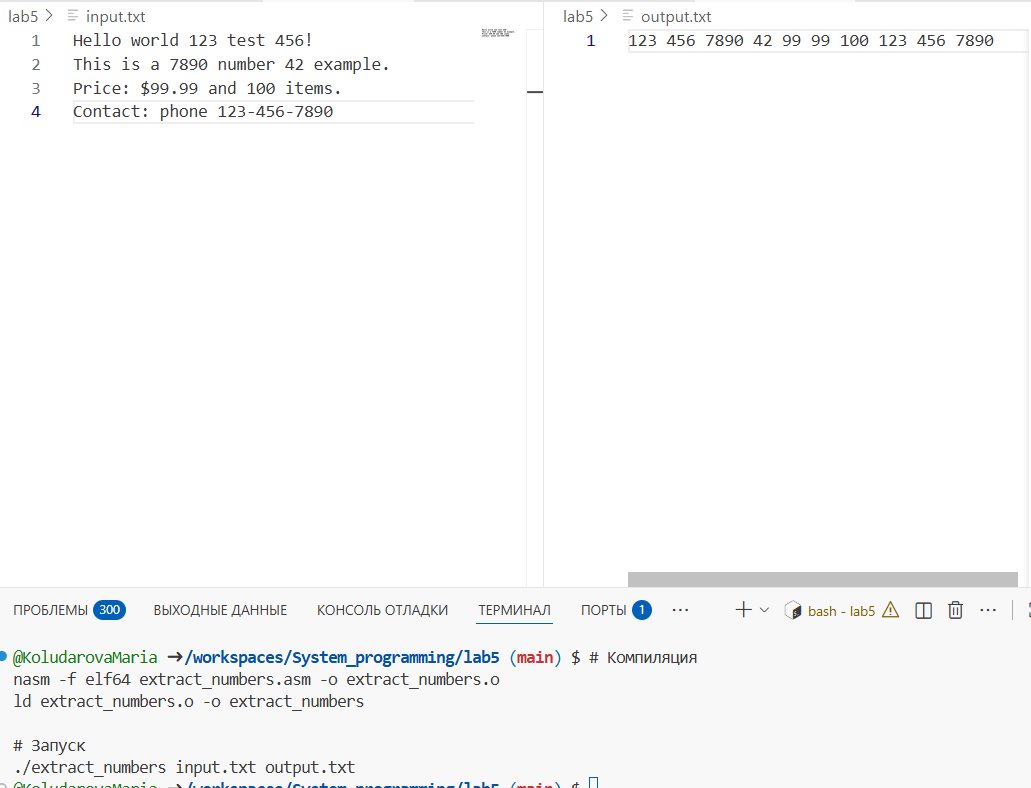